<a href="https://colab.research.google.com/github/Jothish2283/Image-colorization/blob/main/ImageColorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1.1. Getting the data**

In [47]:
import torch
from torch import nn
!pip -q install torchinfo
!pip -q install torch_snippets
!pip install torchview
!pip -q install graphviz
import graphviz
from torchview import draw_graph
from torch_snippets import *
import torchinfo
import torchvision

In [29]:
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [30]:
data_folder= 'cifar10/'
torchvision.datasets.CIFAR10(data_folder, download=True)

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10/
    Split: Train

In [31]:
class Colorize(torchvision.datasets.CIFAR10):
  def __init__(self, root, train):
    super().__init__(root, train)

  def __getitem__(self, ix):
    im, _= super().__getitem__(ix)
    bw=im.convert("L").convert("RGB")
    bw, im=np.array(bw)/255., np.array(im)/255.
    bw, im= [torch.tensor(i).permute(2,0,1).to(device).float() for i in [bw, im]]
    return bw, im

In [32]:
train_data=Colorize(data_folder, train=True)
val_data=Colorize(data_folder, train=False)

train_dataloader= torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader= torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)

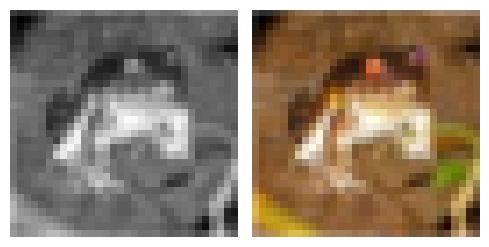

In [33]:
bw_im, c_im= train_data[0]
subplots([bw_im.to("cpu").numpy(), c_im.to("cpu").numpy()], nc=2)

#**1.2. Model creation**

In [34]:
class Identity(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, x):
    return x

class DownConv(nn.Module):
  def __init__(self, c_in, c_out, maxpool=True):
    super().__init__()
    self.model=nn.Sequential(nn.MaxPool2d(2) if maxpool else Identity(), #reduces the size by 2
                             nn.Conv2d(c_in, c_out, 3, padding=1), #padding=1, k=3 keeps the size intact
                             nn.BatchNorm2d(c_out),
                             nn.LeakyReLU(0.2, inplace=True),
                             nn.Conv2d(c_out, c_out, 3, padding=1),
                             nn.BatchNorm2d(c_out),
                             nn.LeakyReLU(0.2, inplace=True))
  def forward(self, x):
    return self.model(x)

class UpConv(nn.Module):
  def __init__(self, c_in, c_out, maxpool=True):
    super().__init__()
    self.conv_t=nn.ConvTranspose2d(c_in, c_out, 2,  stride=2) #2 X inp_size
    self.conv_layer=nn.Sequential(nn.Conv2d(c_out*2, c_out, 3, padding=1),
                                  nn.BatchNorm2d(c_out),
                                  nn.LeakyReLU(0.2, inplace=True),
                                  nn.Conv2d(c_out, c_out, 3, padding=1),
                                  nn.BatchNorm2d(c_out),
                                  nn.LeakyReLU(0.2, inplace=True))
  def forward(self, x, y):
    x=self.conv_t(x)
    x=torch.cat([x,y], dim=1)
    x= self.conv_layer(x)
    return x

In [35]:
class UNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.d1=DownConv(3, 64, maxpool=False)
    self.d2=DownConv(64, 128)
    self.d3=DownConv(128, 256)
    self.d4=DownConv(256, 512)
    self.d5=DownConv(512,1024)
    self.u5=UpConv(1024, 512)
    self.u4=UpConv(512, 256)
    self.u3=UpConv(256, 128)
    self.u2=UpConv(128, 64)
    self.u1=nn.Conv2d(64, 3, kernel_size=1, stride=1)

    self.mse_l=nn.MSELoss()

  def forward(self, x):
    x0=self.d1(x)
    x1=self.d2(x0)
    x2=self.d3(x1)
    x3=self.d4(x2)
    x4=self.d5(x3)
    x4=self.u5(x4, x3)
    x3=self.u4(x4, x2)
    x2=self.u3(x3, x1)
    x1=self.u2(x2, x0)
    x0=self.u1(x1)
    return x0

  def criterion(self, y, y_p):
    loss=self.mse_l(y_p, y)
    return loss

In [36]:
def get_model():
  model=UNet().to(device)
  optimizer=torch.optim.Adam(params=model.parameters())
  return model, optimizer, model.criterion

In [37]:
def train_step(model, data, optimizer, criterion):
  model.train()
  x, y= data
  y_p=model(x)
  optimizer.zero_grad()
  loss=criterion(y, y_p)
  loss.backward()
  optimizer.step()
  return loss.item()

def validate_step(model, data, criterion):
  model.eval()
  with torch.inference_mode():
    x, y= data
    y_p=model(x)
    loss=criterion(y, y_p)
    return loss

In [38]:
model, optimizer, criterion= get_model()
lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True)

EPOCHS=25

In [46]:
torchinfo.summary(model, input_size=(1,3,224,224), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
UNet                                     [1, 3, 224, 224]          [1, 3, 224, 224]          --                        True
├─DownConv: 1-1                          [1, 3, 224, 224]          [1, 64, 224, 224]         --                        True
│    └─Sequential: 2-1                   [1, 3, 224, 224]          [1, 64, 224, 224]         --                        True
│    │    └─Identity: 3-1                [1, 3, 224, 224]          [1, 3, 224, 224]          --                        --
│    │    └─Conv2d: 3-2                  [1, 3, 224, 224]          [1, 64, 224, 224]         1,792                     True
│    │    └─BatchNorm2d: 3-3             [1, 64, 224, 224]         [1, 64, 224, 224]         128                       True
│    │    └─LeakyReLU: 3-4               [1, 64, 224, 224]         [1, 64, 224, 224]         --                        --
│    │ 

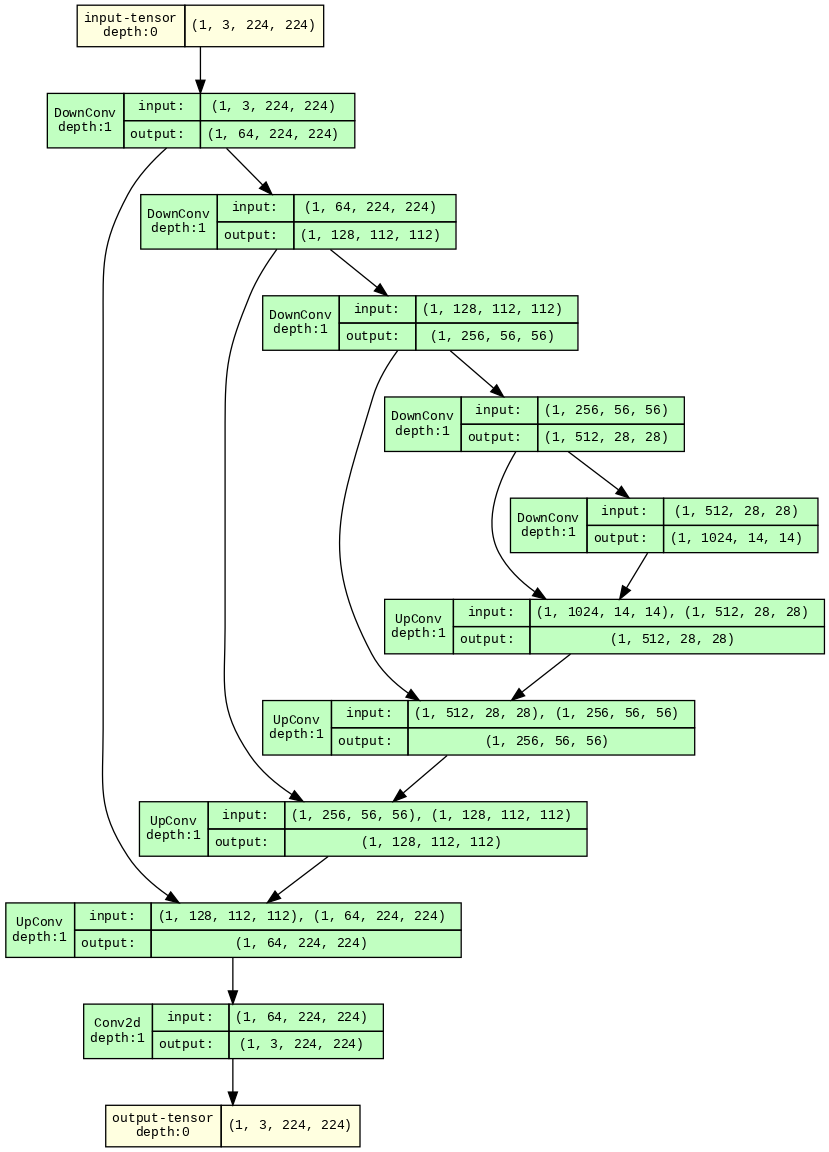

In [48]:
graphviz.set_jupyter_format('png')
model_graph = draw_graph(model, input_size=(1,3,224,224), expand_nested=True, graph_name="unet_model", save_graph=True, depth=1)
model_graph.visual_graph

#**1.3. Run Model**

In [39]:
log=Report(EPOCHS)
for epoch in range(EPOCHS):
  n=len(train_dataloader)
  for idx, data in enumerate(train_dataloader):
    loss=train_step(model, data, optimizer, criterion)
    log.record(epoch+(idx+1)/n, train_loss=loss, end="\r")

  n=len(val_dataloader)
  for idx, data in enumerate(val_dataloader):
    loss= validate_step(model, data, criterion)
    log.record(epoch+(idx+1)/n, val_loss=loss.item(), end="\r")

  lr_scheduler.step(loss)
  log.report_avgs(epoch+1)

EPOCH: 1.000  train_loss: 0.009  val_loss: 0.006  (103.84s - 2492.24s remaining)
EPOCH: 2.000  train_loss: 0.006  val_loss: 0.007  (205.92s - 2368.02s remaining)
EPOCH: 3.000  train_loss: 0.006  val_loss: 0.006  (307.64s - 2256.00s remaining)
EPOCH: 4.000  train_loss: 0.006  val_loss: 0.006  (411.04s - 2157.94s remaining)
EPOCH: 5.000  train_loss: 0.006  val_loss: 0.005  (512.50s - 2050.01s remaining)
EPOCH: 6.000  train_loss: 0.006  val_loss: 0.005  (614.17s - 1944.89s remaining)
EPOCH: 7.000  train_loss: 0.006  val_loss: 0.005  (718.67s - 1848.01s remaining)
EPOCH: 8.000  train_loss: 0.005  val_loss: 0.005  (820.17s - 1742.86s remaining)
EPOCH: 9.000  train_loss: 0.005  val_loss: 0.005  (922.01s - 1639.12s remaining)
EPOCH: 10.000  train_loss: 0.005  val_loss: 0.005  (1023.32s - 1534.97s remaining)
EPOCH: 11.000  train_loss: 0.005  val_loss: 0.005  (1125.12s - 1431.97s remaining)
EPOCH: 12.000  train_loss: 0.005  val_loss: 0.005  (1226.69s - 1328.92s remaining)
EPOCH: 13.000  train_l

100%|██████████| 126/126 [00:01<00:00, 75.55it/s] 


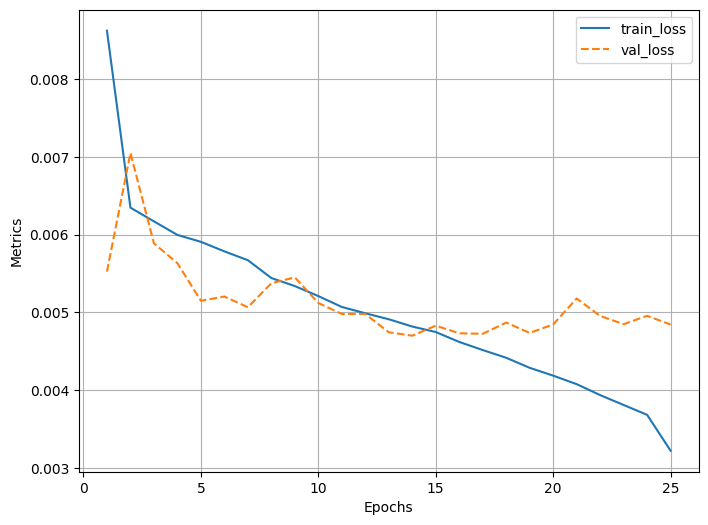

In [40]:
log.plot_epochs()

#**1.4. Testing on val images**

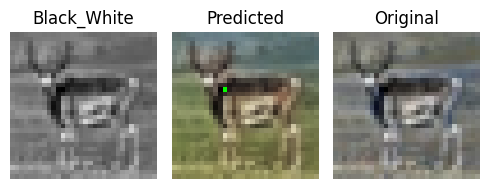

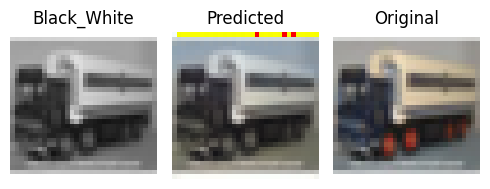

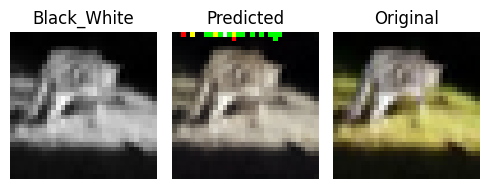

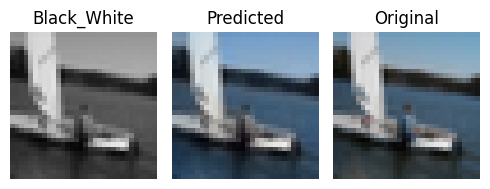

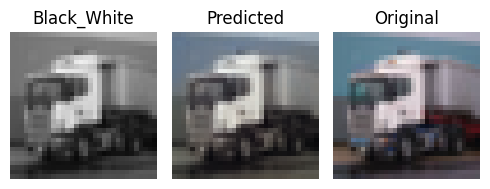

In [41]:
val_dataloader=torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=True)
for i in range(5):
  bw, c= next(iter(val_dataloader))
  c_p=model(bw)
  bw, c_p, c=[i.detach().to("cpu").numpy() for i in[bw, c_p, c]]
  bw, c_p, c=[(i*255).astype(np.uint8) for i in[bw, c_p, c]]
  subplots([bw[0], c_p[0], c[0]], nc=3, titles=["Black_White", "Predicted", "Original"])